<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/binary_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convert binary file to text file

In [4]:
import struct         # for binary data
import numpy as np

Unlike text files, the contents of binary files cannot be viewed directly. We have to know the exact internal structure of the file to work with it. The binary files are read/written faster compared to text files, and their size is smaller than the corresponding text versions.

Both binary and text files consist of bits, but the interpretation is different. In a simple text file, each byte stores a character code (for example, 97 is the code for 'a'). In case of a binary file, we have to interpret different length of bytes to get a number (for example, 4 bytes for an integer, 8 bytes for a float).

Let's suppose we have the following serie of 64 bits in our binary file:

10010010110010011011001010000111110111111101101011010111100011

We can interpret these bits as one double precision value (1 \* 8 bytes), as two float values (2 \* 4 bytes), as two integers (2 \* 4 bytes) values, or as 8 bytes.

| type | value                                |
|------|--------------------------------------|
|double| 6.489242430563902e-132               |
|float | -1.0007766626021244e+34, 7.737921920620381e-17  |
|int   | -134826525, 615672993                |
|byte  | -29, -75, -10, -9, -95, 108, -78, 36 |


In [ ]:
b = 0b10010010110010011011001010000111110111111101101011010111100011    # an integer value
val = b.to_bytes(8, 'little')                                           # change to byte array
print('byte array: ', val)
byte = struct.unpack('8b', val)
print('bytes     :', byte)
i = struct.unpack('2i', val)
print('integers  :', i)
f = struct.unpack('2f', val)
print('floats    :', f)
d = struct.unpack('d', val)
print('double    :', d)

byte array:  b'\xe3\xb5\xf6\xf7\xa1l\xb2$'
bytes     : (-29, -75, -10, -9, -95, 108, -78, 36)
integers  : (-134826525, 615672993)
floats    : (-1.0007766626021244e+34, 7.737921920620381e-17)
double    : (6.489242430563902e-132,)


Any of them can be valid and we cannot decide from the binary values which interpretation should be used.

##The binary file

We'll convert the digital sandbox binary grid format to an ASCII grid file. These files are usually used to store digital elevation models (DEM).

The grid binary format contains integer and float numbers. Our input file starts with two integers, the number of rows and columns in the grid. It follows the bounding box of the grid, four float data. Finally, the elevations in the grid come as float numbers.

Let's download a sample binary file.

In [11]:
!wget -O sample_data/test.grid https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/test.grid

--2023-01-22 12:42:02--  https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/test.grid
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1226904 (1.2M) [application/octet-stream]
Saving to: ‘sample_data/test.grid’

sample_data/test.gr 100%[===================>]   1.17M  --.-KB/s    in 0.006s  

2023-01-22 12:42:02 (181 MB/s) - ‘sample_data/test.grid’ saved [1226904/1226904]



The *struct* standard Python package will be used to change the binary data stream to values.

##Reading and converting binary data

In [13]:
ifile = open('sample_data/test.grid', "rb")         # open binary input file
idataset = ifile.read()                             # read all data into memory
cols, rows = struct.unpack("2i", idataset[:8])    # get column and row count
xul, ylr, xlr, yul = struct.unpack("4f", idataset[8:24])  # get extent of grid
psize = (xlr - xul) / cols                          # pixel size
data = struct.unpack("f" * (rows * cols), idataset[24:])    # elevations
print(f"columns: {cols}  rows: {rows}")
print(f"extent: {xul:.2f},{ylr:.2f} {xlr:.2f},{yul:.2f}")
print(f"max. elev. {max(data):.2f}  min. elev. {min(data):.2f}")

columns: 639  rows: 480
extent: 609913.25,4267994.50 610004.62,4268061.50
max. elev. 11.85  min. elev. -32767.00


Minimum elevation is a strange value. This is not a valid elevation, being used to mark no data value (n/a in text files).

In [14]:
dat = np.array(data)
noDatas = dat[dat< -32000].size
print(f'{noDatas / (cols * rows) * 100:.1f}% is no data value')

0.2% is no data value


##Export data to ASCII GRID format



In [15]:
with open('sample_data/test.asc', 'w') as ofile:
  # write header
  print(f"NCOLS {cols}", file=ofile)
  print(f"NROWS {rows}", file=ofile)
  print(f"XLLCORNER {xul:.2f}", file=ofile)
  print(f"YLLCORNER {yul:.2f}", file=ofile)
  print(f"CELLSIZE {psize:.2f}", file=ofile)
  print(f"NODATA_VALUE -32767", file=ofile)
  for i in range(rows):
    for j in range(cols):
      print(f"{data[i * cols + j]} ", end="", file=ofile)
    print(" ", file=ofile)

ASCII GRID files can be used in several GIS software, for example in QGIS. Here we use matplotlib to display data.

In [16]:
!head sample_data/test.asc    # first ten rows of the ASCII GRID file

NCOLS 639
NROWS 480
XLLCORNER 609913.25
YLLCORNER 4268061.50
CELLSIZE 0.14
NODATA_VALUE -32767
-32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -32767.0 -3276

##Display of the grid

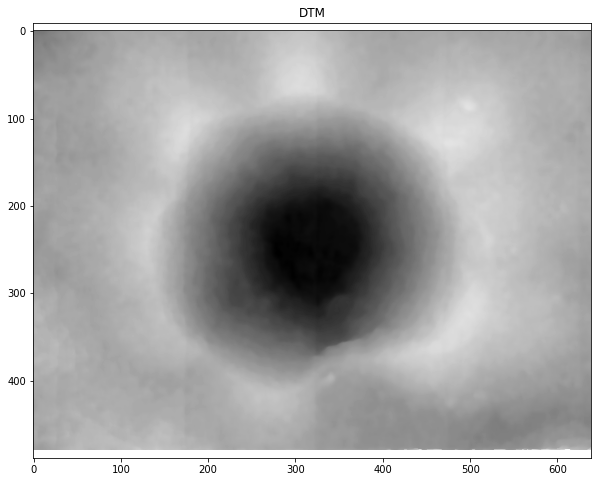

In [26]:
import numpy as np
import matplotlib.pyplot as plt
grid=np.array(data).reshape(rows,cols)            # convert to numpy 2D array
grid[grid < -32760] = 0                           # change nodata values to zero
color = (grid / np.max(grid) * 255).astype(int)   # change elevation to grayscale
fig = plt.figure(figsize=(10,8))
plt.imshow(color, cmap='gray')
plt.axis('equal')
_ = plt.title("DTM")

**Tasks**

*   Display the ASCII GRID in QGIS
*   Collect the binary file types you have used so far
*   Change the colors of the plot to be more convetional to topography
*   Using the Augmented Reality Sandbox, create a binary grid file and convert it to ASCII GRID
*   Write the program to convert files in the opposit direction ASCII GRID to binary (use *pack* function of *struct* package)
*   Try to display GRID data in 3D (*surfaceplot*)
*   Try to processs other binary files with Python

